In [1]:
%load_ext autoreload
%matplotlib widget
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tqdm.autonotebook import trange
from keras.datasets import mnist

%autoreload 1
%aimport jsi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-03-27 11:51:35.221097: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 11:51:35.256797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:51:35.646191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_213785/2990024677.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange
2024-03-27 11:

Num GPUs Available:  1


2024-03-27 11:51:36.466143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 11:51:36.466352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [30]:
# training dataset generation
data_len = 100000

# Define a function to create a serialized tf.train.Example
def create_example(data, label):
    feature = {
        "data": tf.train.Feature(float_list=tf.train.FloatList(value=data.flatten())),
        "label": tf.train.Feature(float_list=tf.train.FloatList(value=label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Write examples to a TFRecord file
filename = "100k_sqrt_noise.tfrecord"
with tf.io.TFRecordWriter(filename) as writer:
    for i in trange(data_len):
        js = np.random.uniform(low=0.0, high=1, size=(3, 5))
        phis = np.random.uniform(low=0.0, high=2*np.pi, size=(3, 5))
        loss = np.random.uniform(low=0.1, high=0.5, size=(2, 3, 28*2))
        g = np.random.uniform(low=0.0, high=0.05)
        input = {
            'nodes' : 28,
            'padding' : 0,
            'n_rings' : 3,
            'orth_itr' : 1,
            'length': 5,
            'js': np.array(js * np.exp(1j * phis), dtype=np.complex64), 
            'jr': np.array(loss[0], dtype=np.complex64), 
            'g': np.array([g], dtype=np.complex64), 
            'y0s': np.array(loss[1], dtype=np.complex64) 
        }
        _, _, output = jsi.jsi_backprop(input, train=False)
        # try:
        #     plt.close(fig)
        # except:
        #     pass
        # fig=jsi.pltSect(output, 0, 0, 28, 28)
        if np.isnan(output).any():
            data_len += 1
            continue
        output_norm = np.abs(output) / np.max(np.abs(output))
        example = create_example(output_norm, np.concatenate((js.flatten(), phis.flatten(), loss.flatten(), [g]), axis=0))
        writer.write(example.SerializeToString())


  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# Read from TFRecord file
# Create a dataset from the TFRecords file
dataset = tf.data.TFRecordDataset(["my_dataset.tfrecord"])

# Define the feature description (adjust shapes and types as needed)
feature_description = {
    'data': tf.io.FixedLenFeature([28*28], tf.float32),
    'label': tf.io.FixedLenFeature([3*5*2+2*3*28*2+1], tf.float32)
}

# Parse the serialized example
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Apply the parsing function to each example
parsed_dataset = dataset.map(_parse_function)

# Process the data
try:
    for example in parsed_dataset:
        data, label = example['data'], example['label']
        print("data: ", len(data))
        print("label: ", len(label))
except tf.errors.OutOfRangeError:
    print("Finished reading data.")

In [28]:
# training using cnn
input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 5,
    'orth_itr' : 1,
    'length': 5
}
model = jsi.jsi_conv(input, "mnist", epochs=5)
model.save('./models/mnist_e5.keras')

Epoch 1/5


3750/3750 [==============================] - ETA: 0s - loss: 0.5482INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7264s 2s/step - loss: 0.5482
Epoch 2/5
3750/3750 [==============================] - ETA: 0s - loss: 0.4570INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7548s 2s/step - loss: 0.4570
Epoch 3/5
3750/3750 [==============================] - ETA: 0s - loss: 0.4427INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7456s 2s/step - loss: 0.4427
Epoch 4/5
3750/3750 [==============================] - ETA: 0s - loss: 0.4346INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7155s 2s/step - loss: 0.4346
Epoch 5/5
3750/3750 [==============================] - ETA: 0s - loss: 0.4280INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7307s 2s/step - loss: 0.4280


In [41]:
# additional training
input['model'] = model
model = jsi.jsi_conv(input, "mnist", epochs=1)
model.save('./models/mnist_e11.keras')

3750/3750 [==============================] - ETA: 0s - loss: 0.3464INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7455s 2s/step - loss: 0.3464


In [13]:
# load model from file
input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 5,
    'orth_itr' : 1,
    'length': 5,
    'model': './models/mnist_e5.keras'
}
model = jsi.jsi_conv(input, "mnist", epochs=2)
model.save('./models/mnist_e13.keras')

Epoch 1/2
3750/3750 [==============================] - ETA: 0s - loss: 0.3354INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7902s 2s/step - loss: 0.3354
Epoch 2/2
3750/3750 [==============================] - ETA: 0s - loss: 0.3256INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7901s 2s/step - loss: 0.3256


313/313 [==============================] - 1s 2ms/step
tf.Tensor(
[[ 9.6815667e-05+2.6342343e-07j -6.2173390e-04-2.0768839e-06j
  -3.7923397e-04+3.4395784e-06j  3.1508240e-04+5.8356039e-07j
   1.2078911e-04-5.1051296e-07j]
 [-6.4087874e-04+1.8468479e-06j  4.2414948e-04-5.5300933e-07j
  -3.5552061e-05+3.2614068e-08j  6.5494140e-05+1.5189488e-07j
   5.3756881e-05-1.0091041e-07j]
 [ 1.5994172e-04+3.9677283e-07j -2.6942505e-06+7.7815718e-09j
  -4.2545391e-04-2.9311702e-06j -1.7632102e-04-1.3668485e-07j
  -9.4214053e-04+4.4489717e-08j]
 [-5.4609601e-04-1.0264455e-06j -2.6491549e-04+1.7962425e-09j
   1.4713187e-05+6.5930671e-08j  1.3069379e-04-1.4821649e-07j
   1.0486020e-04-3.5973119e-07j]
 [ 2.9512899e-04+1.9730696e-06j -3.8260795e-04+1.1024833e-06j
  -2.2807285e-04-5.8592337e-07j -9.7157940e-04+6.8208220e-07j
   8.8705576e-04+3.4924296e-06j]], shape=(5, 5), dtype=complex64)


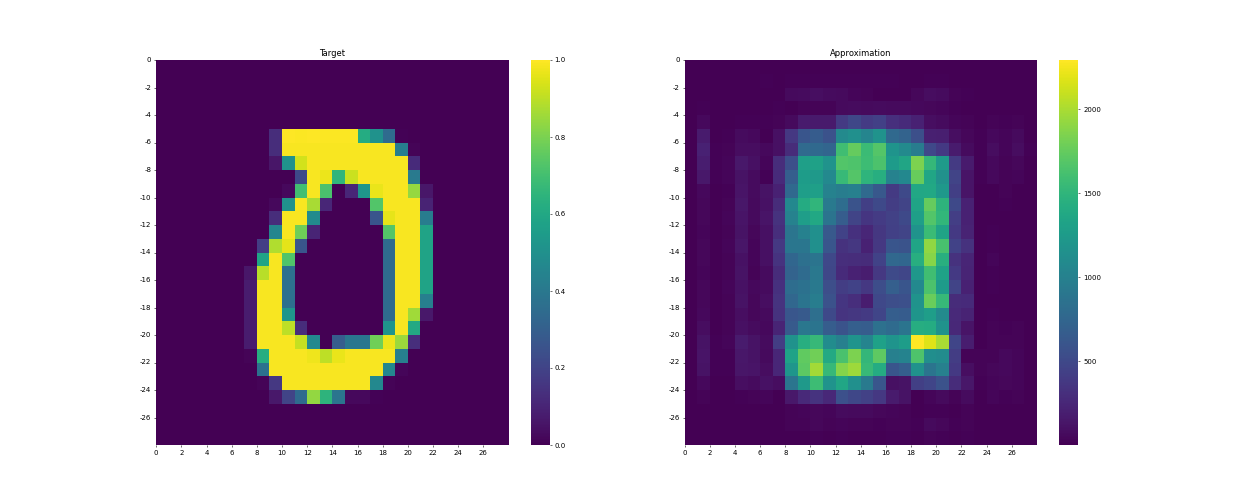

In [26]:
# verify against mnist data
# index of the mnist model
index = 28

(train_X, train_y), (test_X, test_y) = mnist.load_data()

pred = model.predict(test_X / 255)
nodes = 28
n_rings = 5
length = 5
padding = 0
nodes_t = nodes + 2 * padding
input = {
    'nodes' : nodes,
    'padding' : padding,
    'n_rings' : n_rings,
    'orth_itr' : 10,
    'length': length,
    'js': tf.cast(tf.reshape(pred[index][0:n_rings * length], (n_rings, length)), dtype=tf.complex64) * tf.exp(1j * tf.cast(tf.reshape(pred[index][n_rings * length:n_rings * length * 2], (n_rings, length)), dtype=tf.complex64)), 
    'jr': tf.cast(tf.reshape(pred[index][n_rings*length*2 : n_rings*length*2+nodes_t*2*n_rings], (n_rings, nodes_t*2)), dtype=tf.complex64), 
    'g': tf.cast(pred[index][-1], dtype=tf.complex64), 
    'y0s': tf.cast(tf.reshape(pred[index][n_rings*length*2+nodes_t*2*n_rings:n_rings*length*2+nodes_t*4*n_rings], (n_rings, nodes_t*2)), dtype=tf.complex64)
}
print(input['js'])
_, _, output = jsi.jsi_backprop(input, train=False)
try:
    plt.close(fig)
except:
    pass
fig = jsi.pltCtst(test_X[index] / 255, output, 0, 0, 28, 28)

1/1 [==============================] - 0s 65ms/step
[[ 0.02280674+3.20454710e-04j -0.00965372-1.62608019e-04j
   0.00208065-1.94166987e-05j -0.00021906+3.08451327e-08j
   0.00139159+2.40655709e-06j]
 [-0.00929648+3.69102811e-04j -0.00786092+1.14840674e-04j
  -0.00227229+4.20775061e-04j  0.01356955+1.64773286e-04j
   0.00199577+2.19785492e-04j]
 [ 0.00207699-1.18379772e-04j -0.01612393-5.72204415e-04j
  -0.01421094+6.63397426e-04j  0.01530916+1.09554014e-04j
  -0.00991191-3.85979110e-05j]]


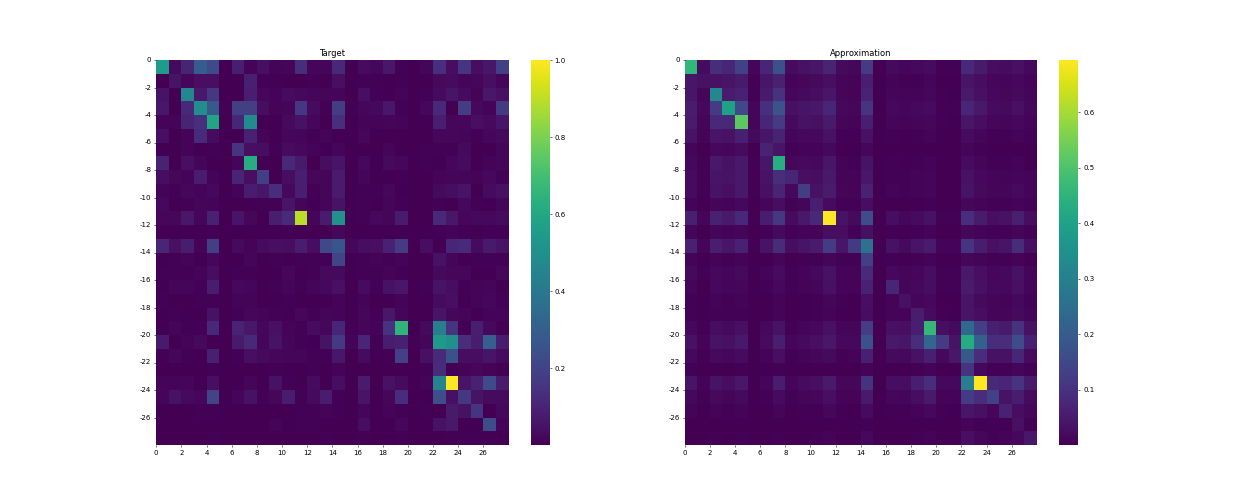

In [7]:
# verify against jsi generated with some constraint

js = np.random.uniform(low=0.0, high=1, size=(3, 5))
phis = np.random.uniform(low=0.0, high=2*np.pi, size=(3, 5))
loss = np.random.uniform(low=0.0, high=0.5, size=(2, 3, 28*2))
g = np.random.uniform(low=0.0, high=0.1)
# loss = np.ones((2, 3, 28*2)) / 10
# g = 0.03
input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 3,
    'orth_itr' : 10,
    'length': 5,
    'js': np.array(js * np.exp(1j * phis), dtype=np.complex64), 
    'jr': np.array(loss[0], dtype=np.complex64), 
    'g': np.array([g], dtype=np.complex64), 
    'y0s': np.array(loss[1], dtype=np.complex64) 
}
_, _, output = jsi.jsi_backprop(input, train=False)
target = np.abs(output) / np.max(np.abs(output))

index = 0
pred = model.predict(np.array([target]))

input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 3,
    'orth_itr' : 10,
    'length': 5,
    'js': np.array(pred[index][0:15].reshape((3, 5)) * np.exp(1j * pred[index][15:30].reshape((3, 5))), dtype=np.complex64), 
    'jr': np.array(pred[index][30:198].reshape((3, 56)), dtype=np.complex64), 
    'g': np.array([pred[index][-1]], dtype=np.complex64), 
    'y0s': np.array(pred[index][198:366].reshape((3, 56)), dtype=np.complex64) 
}
print(input['js'])
_, _, output = jsi.jsi_backprop(input, train=False)
try:
    plt.close(fig)
except:
    pass
fig = jsi.pltCtst(target, output, 0, 0, 28, 28)